### Numba code working for the underdamped case



In [4]:
import numpy as np
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
%matplotlib inline
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}

matplotlib.rc('font', **font)


import time as time

# -------------- SET UP YOUR PATH ------------
import sys
sys.path.append("~/OneDrive/ExtendedProject/Code/Weak SDE approximation/C++")

import numpy as np
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
%matplotlib inline
# font = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 17}

# matplotlib.rc('font', **font)

import scipy.integrate as integrate
## ---------------- Mathplotlib settings ----------------
SMALL_SIZE = 12
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [5]:
# function to plot numba results 
def plot_qpnumba(qp,tau,gamma):
    fig, (ax1,ax2,ax3)= plt.subplots(1, 3,figsize=(25,8))# plt.figure(figsize=(4,4))
    fig.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)

    fig.suptitle("$\\tau$="+str(tau)+", $\\gamma=$"+str(gamma)+", $N=$"+str(len(qp[::,0])))

    #Plot 1
    ## position q experiment
    histogram,bins = np.histogram(qp[::,0],bins=100,range=[0,1.5], density=True)
    midx_q = (bins[0:-1]+bins[1:])/2
    ax1.plot(midx_q,histogram,label='q-Experiment')
    ax1.legend() 

    #Plot 2: 
    ### momentum p experiment
    histogram,bins = np.histogram(qp[::,1],bins=100,range=[-1.5,1.5], density=True)
    midx_p = (bins[0:-1]+bins[1:])/2
    # histogram=(histogram/np.sum(histogram)*(midx[1]-midx[0]) )
    ax2.plot(midx_p,histogram,label='p-Experiment')

    ### position q true
    rho = np.exp(- U(midx_q)/tau)
    rho = rho / ( np.sum(rho)* (midx_q[1]-midx_q[0]) ) # Normalize rho by dividing by its approx. integral
    ax1.plot(midx_q,rho,'--',label='Truth')
    ax1.legend() 

    ### momentum p true
    rho = np.exp(- (midx_p**2)/(2*tau))
    rho = rho / ( np.sum(rho)* (midx_p[1]-midx_p[0]) ) # Normalize rho by dividing by its approx. integral
    ax2.plot(midx_p,rho,'--',label='Truth')
    ax2.legend() 

    #Plot 3 
    ax3.set_ylim(-5,5)
    ax3.plot(qp[::,1],label="p")
    ax3.plot(qp[::,0],label="q")



    ax3.legend()


## Write adaptive code that saves values at each time

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from numba import jit,njit,vectorize, float64, int32
import numba as nb
import time as time
##############################
# Define some global variables
##############################
M=5
m=0.1
includeD=True # if 1 include divergence term
include_ada = 1 #if 1 make the code adaptive 
printskip=10

def U(x):
    res = (0.5/(x*x)+x*x)
    return res


@njit(float64(float64))
def Up(x):
    res = -1/(x*x*x)+2*x
    return res

@njit(float64(float64))
def getg(x): #,dtmin, dtmax, R):
    x6 = np.power(x,6)
    xi = np.sqrt(m*m+x6)
    g=1./(1./M+1./xi)
    return g

@njit(float64(float64))
def getgprime(x):
    x6 = np.power(x,6);
    x5 = x6/x
    xi = np.sqrt(x6+m*m);
    g =1./(1./M + 1./xi);
    gprime= 3*x5*np.power(g,2)/np.power(xi,3)
    return gprime

@njit(float64[:,:](float64[:],float64,float64,float64,float64))
def one_traj_ada(qp,Nt,dt,gamma,tau):
    t=0
    q=qp[0]
    p=qp[1]

    #useful things to compute for first step
    f = -Up(q)
    g=1
    if include_ada==1:     #Turn on the code to be adaptive
        g=getg(q)
    if includeD==True:
        gp=getgprime(q)
    
    gdt=g*dt

    #set up vectors to save results 
    size_save = int(Nt/printskip)
    tqpg_list = np.zeros((size_save,4))
    save_i=0 

    for count in range(Nt):
        #**********
        #* STEP B *
        #**********
        p +=0.5*gdt*f 
            # step B with extra term in in
        if includeD==True:
            p += 0.5*dt*tau*gp

        #**********
        #* STEP A *
        #**********
        q += 0.5*gdt*p

        #**********
        #* STEP O *
        #**********
        dB = np.random.normal(0,1)
        C =np.exp(-gdt*gamma) 
        p = C*p+ np.sqrt((1-C*C)*tau)*dB

        #**********
        #* STEP A *
        #**********
        q += 0.5*gdt*p

        #**********
        #* STEP B *
        #**********
        # Need to compute new quantities for f and g 
        f = -Up(q)
        g=1
        if include_ada==1:
            g=getg(q)
        gdt=g*dt

        p +=0.5*gdt*f 
            # step B with extra term in it
        if includeD==True:
            gp=getgprime(q)
            p += 0.5*dt*tau*gp

        #*********************************
        #* Save (p,q) and update time and*
        #*********************************
        if count%printskip==0:
            tqpg_list[save_i,0]=t
            tqpg_list[save_i,1]=q
            tqpg_list[save_i,2]=p
            tqpg_list[save_i,3]=g

            save_i+=1

        t+= dt 
    return(tqpg_list)

@njit(parallel=True)
def method_baoab_ada(n_samples,gamma,tau,Nt,h):
    nsample_pertraj = int(Nt/printskip)
    tqpg_list=np.zeros((n_samples*nsample_pertraj,5))
    ones_nsample=np.ones(nsample_pertraj)
    qipi = np.array([2.0,0.0]) #np.random.normal(0,1,2) #initial conditions
    for j in nb.prange(n_samples):
        qp_samples = one_traj_ada(qipi,Nt,h,gamma,tau)
        start_i = nsample_pertraj*j
        end_i = nsample_pertraj*(j+1)
        tqpg_list[start_i:end_i,1:5]=qp_samples
        tqpg_list[start_i:end_i,0]=ones_nsample*j
    return(tqpg_list)

#compile the method
qp = method_baoab_ada(2,0.1,0.1,10,0.1)

### Run the code for a set of parameters with adaptivity turned on

In [7]:
T=100
h = 0.01
gamma = 0.1
tau=0.1
n_samples=100000
Ntimes=int(T*1/h)
qp_ada = method_baoab_ada(n_samples,gamma,tau,Ntimes,h)


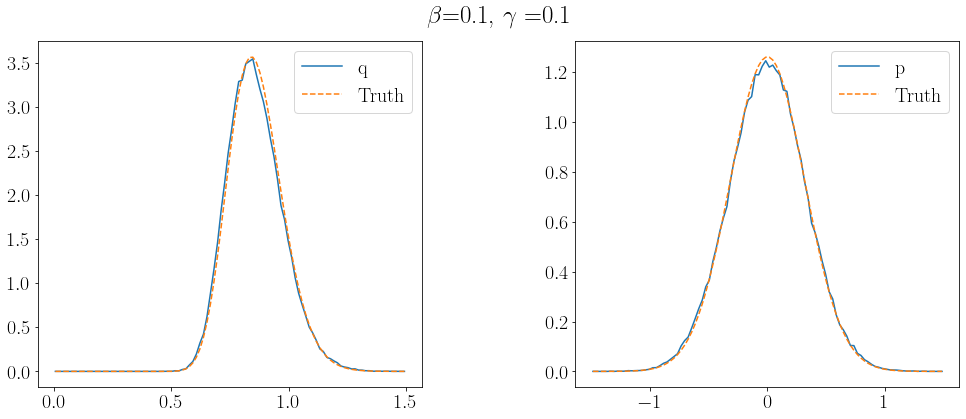

In [8]:
import pandas as pd
df = pd.DataFrame(qp_ada,columns=["sim","t","Q","P","g"])
#Create a dataset with only the final time
idx = df.groupby(['sim'])['t'].transform(max) == df['t'] #Get the indexes of the final time
final_df=df[idx] #Select only dataset with final time
#Get numpy arrays of the final values 
qf_list,pf_list,gf_list,tf_list = np.array(final_df["Q"]), np.array(final_df["P"]), np.array(final_df["g"]), np.array(final_df["t"])

fig, (ax1,ax2)= plt.subplots(1, 2,figsize=(16,6))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)

fig.suptitle("$\\beta$="+str(tau)+", $\\gamma=$"+str(gamma))

#Plot 1
## position q experiment - C CODE
histogram,bins = np.histogram(qf_list,bins=100,range=[0,1.5], density=True)
midx_q = (bins[0:-1]+bins[1:])/2
ax1.plot(midx_q,histogram,label='q')
ax1.legend() 

#Plot 2: 
### momentum p experiment NUMBA CODE
histogram,bins = np.histogram(pf_list,bins=100,range=[-1.5,1.5], density=True)
midx_p = (bins[0:-1]+bins[1:])/2
# histogram=(histogram/np.sum(histogram)*(midx[1]-midx[0]) )
ax2.plot(midx_p,histogram,label='p')

### position q true
rho = np.exp(- U(midx_q)/tau)
rho = rho / ( np.sum(rho)* (midx_q[1]-midx_q[0]) ) # Normalize rho by dividing by its approx. integral
ax1.plot(midx_q,rho,'--',label='Truth')
ax1.legend() 

### momentum p true
rho = np.exp(-(midx_p**2)/(2*tau))
rho = rho / ( np.sum(rho)* (midx_p[1]-midx_p[0]) ) # Normalize rho by dividing by its approx. integral
ax2.plot(midx_p,rho,'--',label='Truth')
ax2.legend() 


### Run the code without adaptivity to compare against

In [4]:
T=100
h = 0.01
gamma = 0.1
tau=0.1
n_samples=100000
Ntimes=int(T*1/h)
qp_non_ada = method_baoab_ada(n_samples,gamma,tau,Ntimes,h)

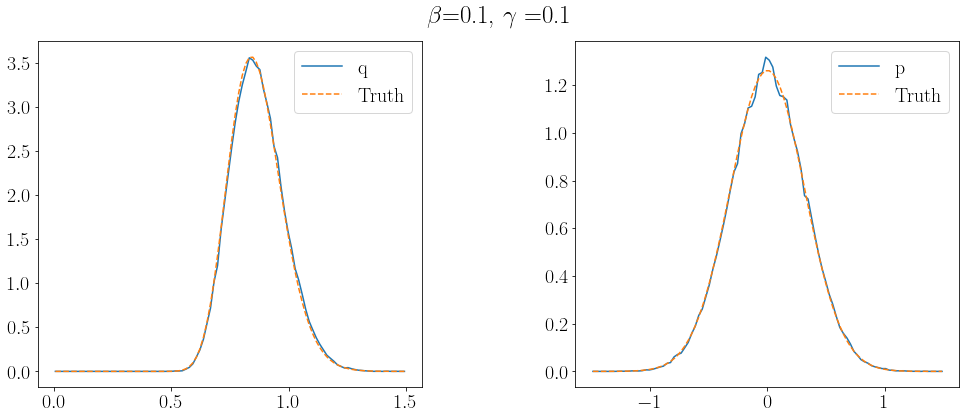

In [5]:
import pandas as pd
df_nonada = pd.DataFrame(qp_non_ada,columns=["sim","t","Q","P","g"])
#Create a dataset with only the final time
idx = df_nonada.groupby(['sim'])['t'].transform(max) == df_nonada['t'] #Get the indexes of the final time
final_df_nonada=df_nonada[idx] #Select only dataset with final time
#Get numpy arrays of the final values 
qf_listnonada,pf_listnonada,gf_listnonada,tf_listnonada = np.array(final_df_nonada["Q"]), np.array(final_df_nonada["P"]), np.array(final_df_nonada["g"]), np.array(final_df_nonada["t"])

fig, (ax1,ax2)= plt.subplots(1, 2,figsize=(16,6))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)

fig.suptitle("$\\beta$="+str(tau)+", $\\gamma=$"+str(gamma))

#Plot 1
## position q experiment - C CODE
histogram,bins = np.histogram(qf_listnonada,bins=100,range=[0,1.5], density=True)
midx_q = (bins[0:-1]+bins[1:])/2
ax1.plot(midx_q,histogram,label='q')
ax1.legend() 

#Plot 2: 
### momentum p experiment NUMBA CODE
histogram,bins = np.histogram(pf_listnonada,bins=100,range=[-1.5,1.5], density=True)
midx_p = (bins[0:-1]+bins[1:])/2
# histogram=(histogram/np.sum(histogram)*(midx[1]-midx[0]) )
ax2.plot(midx_p,histogram,label='p')

### position q true
rho = np.exp(- U(midx_q)/tau)
rho = rho / ( np.sum(rho)* (midx_q[1]-midx_q[0]) ) # Normalize rho by dividing by its approx. integral
ax1.plot(midx_q,rho,'--',label='Truth')
ax1.legend() 

### momentum p true
rho = np.exp(-(midx_p**2)/(2*tau))
rho = rho / ( np.sum(rho)* (midx_p[1]-midx_p[0]) ) # Normalize rho by dividing by its approx. integral
ax2.plot(midx_p,rho,'--',label='Truth')
ax2.legend() 


## Compare evolution of non adaptive and adaptive

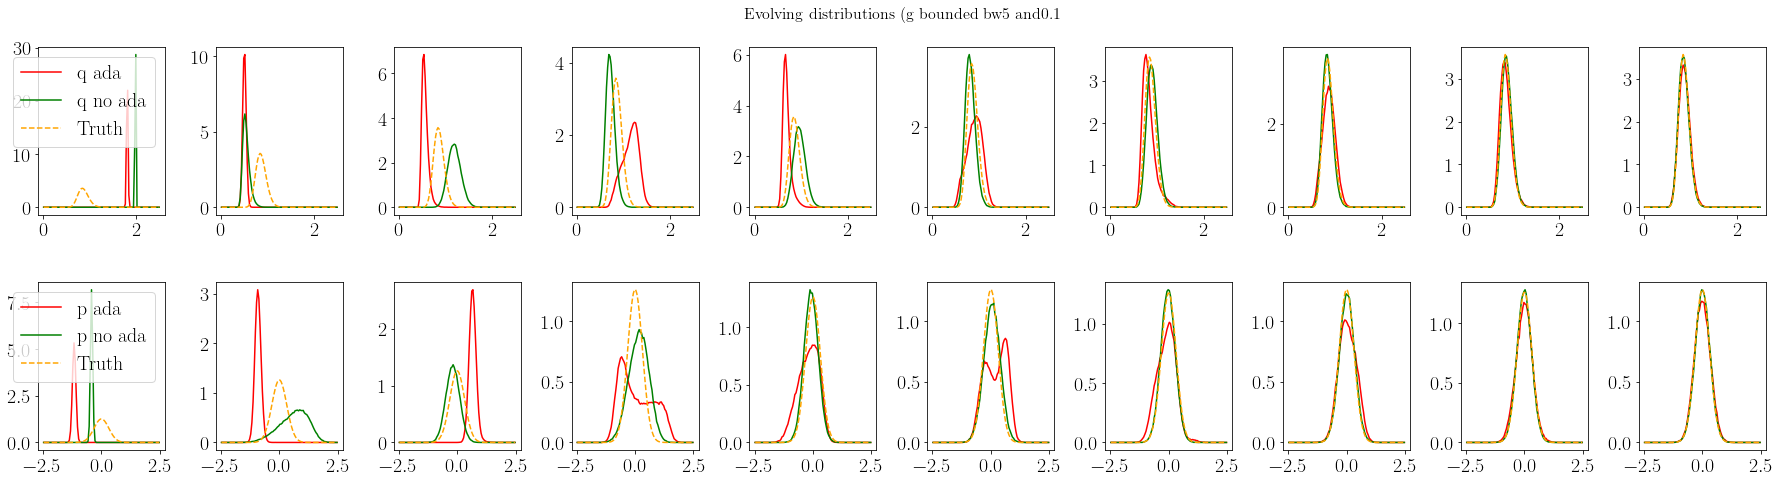

In [14]:
## Get a list of 10 times 
list_time=df['t'].unique()
list_time=list_time[1::100]#

## Set up the plots 
fig, ((axs))= plt.subplots(2,10,figsize=(30,7))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
fig.suptitle('Evolving distributions (g bounded bw'+str(M)+' and' +str(m), fontsize=16)

## Loop through the values 
for i in range(len(list_time)):
    
    # List of time
    ti = list_time[i]
    dfi=df[df['t']==ti]
    dfi_nonada=df_nonada[df_nonada['t']==ti]
    
    # --- Q at time t=ti daptive
    histogram,bins = np.histogram(dfi["Q"],bins=100,range=[0,2.5], density=True)
    midx_q = (bins[0:-1]+bins[1:])/2
    axs[0,i].plot(midx_q,histogram,label='q ada',color="red")
    
    # --- Q at time t=ti non adaptive
    histogram,bins = np.histogram(dfi_nonada["Q"],bins=100,range=[0,2.5], density=True)
    midx_q = (bins[0:-1]+bins[1:])/2
    axs[0,i].plot(midx_q,histogram,label='q no ada',color="green")

    # --- P at time t=ti adaptive
    histogram,bins = np.histogram(dfi["P"],bins=100,range=[-2.5,2.5], density=True)
    midx_p = (bins[0:-1]+bins[1:])/2
    axs[1,i].plot(midx_p,histogram,label='p ada',color="red")
    # --- Q at time t=ti non adaptive
    histogram,bins = np.histogram(dfi_nonada["P"],bins=100,range=[-2.5,2.5], density=True)
    midx_p = (bins[0:-1]+bins[1:])/2
    axs[1,i].plot(midx_p,histogram,label='p no ada',color="green")

    # --- Q true
    rho = np.exp(- U(midx_q)/tau)
    rho = rho / ( np.sum(rho)* (midx_q[1]-midx_q[0]) ) # Normalize rho by dividing by its approx. integral
    axs[0,i].plot(midx_q,rho,'--',label='Truth',color="orange")
    axs[0,0].legend() 

    # --- P true
    rho = np.exp(- (midx_p**2)/(2*tau))
    rho = rho / ( np.sum(rho)* (midx_p[1]-midx_p[0]) ) # Normalize rho by dividing by its approx. integral
    axs[1,i].plot(midx_p,rho,'--',label='Truth',color="orange")
    axs[1,0].legend() 


